In [40]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [55]:
ds, ds_info = tfds.load(
    "cifar10",
    split=["train", "test"],
    as_supervised=True,
    with_info=True
)   

In [56]:
print(ds[0])

<PrefetchDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>


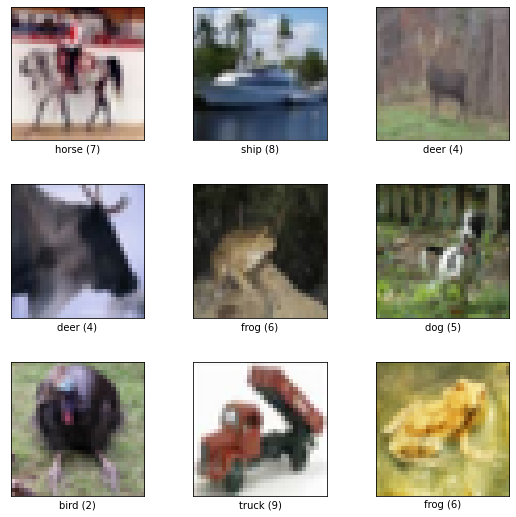

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



In [57]:
tfds.show_examples(ds[0], ds_info)
print(ds_info)
image, label = next(iter(ds[0]))

Preparing the dataset

In [47]:
def normalize_img(image, label):
  """
    Normalizes images: `uint8` -> `float32`.
    Reduces input: id, image, label -> normalized(image), label
  """
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds[0]# tuple('image', 'label')
ds_test = ds[1]

print(ds_train)

ds_train = ds_train.map(normalize_img)
ds_train = ds_train.cache()
ds_train = ds_train.batch(64)
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(normalize_img)
ds_test = ds_test.batch(64)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)


<PrefetchDataset shapes: {id: (), image: (32, 32, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>


In [77]:
model = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(32,32,3)),
    tf.keras.layers.MaxPool2D(2,2),


    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
])


NameError: name 'features' is not defined

In [68]:
class DeCifer(tf.keras.Model):
  def __init__(self):
    super(DeCifer, self).__init__(name='')

    self.conv2_one = tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2))
    self.pool_one = tf.keras.layers.MaxPool2D(2,2)

    self.conv2_two = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same')
    self.pool_two = tf.keras.layers.MaxPool2D(3,3)

    self.conv2_three = tf.keras.layers.Conv2D(16, (1, 1))
    self.flat_three = tf.keras.layers.Flatten()

    self.dense_one = tf.keras.layers.Dense(units=32)
    self.dense_two = tf.keras.layers.Dense(units=10)    

  def call(self, input_tensor, training=False):
    x = self.conv2_one (input_tensor)
    x = tf.nn.relu(x)
    x = self.pool_one (x)

    x = self.conv2_two(x)
    x = tf.nn.relu(x)
    x = self.pool_two(x)
    

    x = self.conv2_three(x)
    x = tf.nn.relu(x)
    x = self.flat_three(x)
    
    x = self.dense_one(x)
    x = self.dense_two(x)

    return tf.nn.softmax(x)


model = DeCifer()


In [69]:
_ = model(tf.zeros((1, 32,32,3)))
model.summary()

Model: "de_cifer_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            multiple                  416       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_7 (Conv2D)            multiple                  9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_8 (Conv2D)            multiple                  528       
_________________________________________________________________
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  1

In [79]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
def loss(model, x, y):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x)

  return loss_object(y_true=y, y_pred=y_)

image, labels = next(iter(ds_train))
l = loss(model, image, labels)
print("Loss test: {}".format(l))


ValueError: input tensor must have rank 4

In [ ]:
tf.nn.softmax(predictions[:5])


In [ ]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))
